In [3]:
import pandas as pd
import nbprogress
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, adjusted_rand_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

In [5]:
# Import the data
df = pd.read_json (r'data/df_machine_learning.json')

# Select each independent Pandas series to a variable
Xtest = df["text"]
ytest = df["true_false"]

# Ignore a filter which will appear due to the loop below
simplefilter("ignore", category=ConvergenceWarning)

# Split training and test datasets
X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.2,random_state=123)

[Text(0, 0.5, 'F1-Score'), Text(0.5, 0, '')]

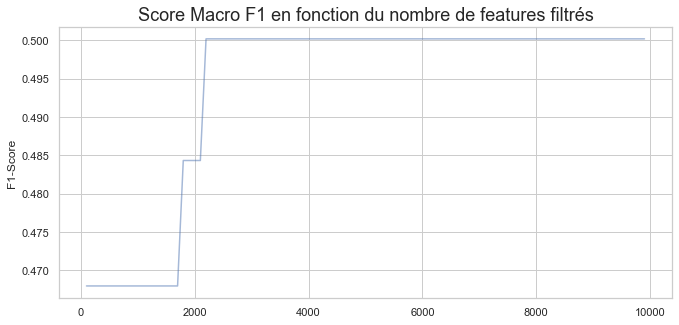

In [3]:
# We create empty lists which we'll use later for a data visualization
iteration = []
f1_model = []

# We want to select the best K features for our model, so we run a loop
for i in nbprogress.log(range(10000), every = 100):
    # We are only interested in running this loop every 100 iteration (runtime/100)
    if i % 100 == 0 and i != 0:
        # We create the pipeline with the tf-idf, features selection and machine learning model
        pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1))),
                             ("chi", SelectKBest(chi2, k = i)),
                             ("clf", LinearSVC())])
        # We apply this pipeline to our training data
        model = pipeline.fit(X_train, y_train)
        # We append the iterator value and the f1-score to our dataframe
        iteration.append(i)
        f1_model.append(f1_score(y_test,model.predict(X_test),average='macro'))

# We make a df out of our iterators
k_candidate = pd.DataFrame(
     {
         'iteration': iteration,
         'f1_score': f1_model
     }
)

# Then plot our k candidates
sns.set(style = 'whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (11, 5))

# Plot the information sources
sns.set_color_codes('muted')
sns.lineplot(x = k_candidate['iteration'],
             y = k_candidate['f1_score'],
             alpha=0.5).set_title('Score Macro F1 en fonction du nombre de features filtrés', fontsize = 18)

# Add an informative axis label
ax.set(ylabel = 'F1-Score',
       xlabel = '')

In [28]:
# Create a pipeline to get the model at 2000 features
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1))),
                    ("chi", SelectKBest(chi2, k = 2000)),
                    ("clf", LinearSVC())])

# Fit the model
model = pipeline.fit(X_train, y_train)

# Get our prediction
prediction = model.predict(X_test)

# Print out the report
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = prediction, output_dict=True)).transpose()
clsf_report

,precision,recall,f1-score,support
FAUX,0.892128,1.000000,0.942989,306.000000
VRAI,1.000000,0.026316,0.051282,38.000000
accuracy,0.892442,0.892442,0.892442,0.892442
macro avg,0.946064,0.513158,0.497136,344.000000
weighted avg,0.904044,0.892442,0.844487,344.000000


In [29]:
pd.DataFrame(
    confusion_matrix(y_test, prediction, labels=['FAUX', 'VRAI']), 
    index=['actual:FAUX', 'actual:VRAI'], 
    columns=['predicted:FAUX', 'predicted:VRAI']
)

,predicted:FAUX,predicted:VRAI
actual:FAUX,306,0
actual:VRAI,37,1


[Text(0, 0.5, 'F1-Score'), Text(0.5, 0, '')]

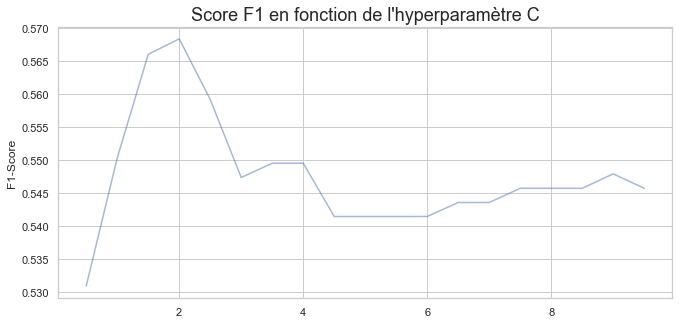

In [10]:
# We create empty lists which we'll use later for a data visualization
iteration = []
f1_model = []

# We want to select the best K features for our model, so we run a loop
for i in nbprogress.log(np.arange(0.0, 10.0, 0.5)):
    if i != 0:
        # We create the pipeline with the tf-idf, features selection and machine learning model
        pipeline = make_pipeline_imb(TfidfVectorizer(),
                         SelectKBest(chi2, k = 2000),
                         SMOTE(random_state = 123),
                         LinearSVC(random_state = 123, C = i, class_weight = 'balanced'))
        # We apply this pipeline to our training data
        model = pipeline.fit(X_train, y_train)
        # We append the iterator value and the f1-score to our dataframe
        iteration.append(i)
        f1_model.append(f1_score(y_test,model.predict(X_test),average='macro'))

# We make a df out of our iterators
k_candidate = pd.DataFrame(
     {
         'iteration': iteration,
         'f1_score': f1_model
     }
)

# Then plot our k candidates
sns.set(style = 'whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (11, 5))

# Plot the information sources
sns.set_color_codes('muted')
sns.lineplot(x = k_candidate['iteration'],
             y = k_candidate['f1_score'],
             alpha=0.5).set_title('Score F1 en fonction de l\'hyperparamètre C', fontsize = 18)

# Add an informative axis label
ax.set(ylabel = 'F1-Score',
       xlabel = '')

In [14]:
# Create a pipeline to get the model at 2000 features with the SMOTE process
pipe = make_pipeline_imb(TfidfVectorizer(),
                         SelectKBest(chi2, k = 2000),
                         SMOTE(random_state = 123),
                         LinearSVC(random_state = 123, C = 2, class_weight = 'balanced'))

# Fit the model
model = pipe.fit(X_train, y_train)

# Get our prediction
prediction = model.predict(X_test)

# Print out the report
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = prediction, output_dict=True)).transpose()
clsf_report

,precision,recall,f1-score,support
FAUX,0.906355,0.885621,0.895868,306.00000
VRAI,0.222222,0.263158,0.240964,38.00000
accuracy,0.816860,0.816860,0.816860,0.81686
macro avg,0.564288,0.574389,0.568416,344.00000
weighted avg,0.830782,0.816860,0.823524,344.00000


In [9]:
pd.DataFrame(
    confusion_matrix(y_test, prediction, labels=['FAUX', 'VRAI']), 
    index=['actual:FAUX', 'actual:VRAI'], 
    columns=['predicted:FAUX', 'predicted:VRAI']
)

,predicted:FAUX,predicted:VRAI
actual:FAUX,268,38
actual:VRAI,29,9


In [32]:
# Create a pipeline to get the model at 2000 features with the SMOTE process and the Naive Bayes algorithm
pipe = make_pipeline_imb(TfidfVectorizer(),
                         SelectKBest(chi2, k = 2000),
                         SMOTE(random_state = 123),
                         MultinomialNB())

# Fit the model
model = pipe.fit(X_train, y_train)

# Get our prediction
prediction = model.predict(X_test)

# Print out the report
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = prediction, output_dict=True)).transpose()
clsf_report

,precision,recall,f1-score,support
FAUX,0.906863,0.604575,0.725490,306.000000
VRAI,0.135714,0.500000,0.213483,38.000000
accuracy,0.593023,0.593023,0.593023,0.593023
macro avg,0.521289,0.552288,0.469487,344.000000
weighted avg,0.821678,0.593023,0.668931,344.000000


In [33]:
pd.DataFrame(
    confusion_matrix(y_test, prediction, labels=['FAUX', 'VRAI']), 
    index=['actual:FAUX', 'actual:VRAI'], 
    columns=['predicted:FAUX', 'predicted:VRAI']
)

,predicted:FAUX,predicted:VRAI
actual:FAUX,185,121
actual:VRAI,19,19


https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2
https://towardsdatascience.com/class-imbalance-a-classification-headache-1939297ff4a4
https://stackoverflow.com/questions/55740220/macro-vs-micro-vs-weighted-vs-samples-f1-score